In [0]:
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Conv2D, MaxPooling2D, Dropout, Input, concatenate, UpSampling2D, Activation, Reshape, Conv2DTranspose, BatchNormalization
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from google.colab import files, drive
from skimage.io import imread, imsave
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np
import os
import io
import zipfile
import cv2
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/tabOCR/'

Mounted at /content/gdrive


In [0]:
#uploaded = files.upload()
#data = zipfile.ZipFile(io.BytesIO(uploaded['dataset_table_simple_columns.zip']), 'r')
#data.extractall()

In [0]:
# generator

In [0]:
class image_generator(Sequence):

    def __init__(self, image_filenames, mask_filenames, batch_size, img_size, n_calsses, loss='categorical_crossentropy', no_reshape=False):
        self.image_filenames, self.mask_filenames = image_filenames, mask_filenames
        self.batch_size = batch_size
        self.height = img_size[0]
        self.width = img_size[1]
        self.n_calsses = n_calsses
        self.no_reshape = no_reshape
        self.loss = loss

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def get_img_array(self, file_name):
      img = cv2.imread(file_name, 3)
      return (cv2.resize(img, (self.width, self.height))/255).astype('float32')

    def get_segmentation_mask(self, file_name, sparse=False):
        img = cv2.imread(file_name, 1)
        img = cv2.resize(img, (self.width, self.height), interpolation=cv2.INTER_NEAREST)
        img = img[:, :, 0]
        img = img.max() - img
        if sparse:
              img = np.reshape(img, (self.height*self.width))
              return np.expand_dims(img,2).astype('uint8')
        seg_labels = np.zeros((self.height, self.width, self.n_calsses))
        for c in range(self.n_calsses):
          seg_labels[:, :, c] = (img == c).astype(int)
        if not self.no_reshape:
          seg_labels = np.reshape(seg_labels, (self.height*self.width, self.n_calsses))
        return seg_labels.astype('bool')
  
    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        if self.loss == 'categorical_crossentropy':
           return (np.array([self.get_img_array(file_name) for file_name in batch_x]),
                   np.array([self.get_segmentation_mask(file_name) for file_name in batch_y]))
        else:
           return (np.array([self.get_img_array(file_name) for file_name in batch_x]),
                   np.array([self.get_segmentation_mask(file_name) for file_name in batch_y]))

In [0]:
input_height = 336
input_width = 704
n_classes = 2
batch_size = 4
steps_per_epoch = 600
model_name = "table_simple_columns_m4_v11"
loss = 'binary_crossentropy'

In [0]:
# from drive
'''
image_filenames = []
mask_filenames = []
for path, _, files in os.walk(root_path + "table_imgs_train"):
    for f in files:
        imgs.append(os.path.join(path, f))
for path, _, files in os.walk(root_path + "table_mask_train"):
    for f in files:
        masks.append(os.path.join(path, f))
train_generator = generator_disk(image_filenames, mask_filenames, batch_size=4, img_size=(input_height, input_width), n_calsses=n_classes, loss=loss)
'''

# from uploaded
image_filenames = list(map(lambda s: "image_table_train/" + s, sorted(os.listdir('image_table_train'))))
mask_filenames = list(map(lambda s: "mask_column_borders_train/" + s, sorted(os.listdir('mask_column_borders_train'))))
image_filenames_val = list(map(lambda s: "image_table_val/" + s, sorted(os.listdir('image_table_val'))))
mask_filenames_val = list(map(lambda s: "mask_column_borders_val/" + s, sorted(os.listdir('mask_column_borders_val'))))
train_generator = image_generator(image_filenames, mask_filenames, batch_size=batch_size, img_size=(input_height, input_width), n_calsses=n_classes, loss=loss)
val_generator = image_generator(image_filenames_val, mask_filenames_val, batch_size=batch_size, img_size=(input_height, input_width), n_calsses=n_classes, loss=loss)

In [0]:
# model

In [0]:
# model 1
'''
img_input = Input(shape=(input_height,input_width , 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.5)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((4, 4))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.5)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)

pool2 = MaxPooling2D((2, 2))(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.5)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)

pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.5)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv3)
up1 = concatenate([u3, conv2], axis=-1)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.5)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
# pool3 = MaxPooling2D((2, 2))(conv4)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
conv5 = Dropout(0.5)(conv5)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

u4 = Conv2DTranspose(32, (2, 2), strides=(4, 4), padding='same') (conv5)
up2 = concatenate([u4, conv1], axis=-1)

conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv6 = Dropout(0.5)(conv6)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

out = Conv2D(n_classes, (1, 1) , padding='same')(conv6)

out = Reshape((input_height*input_width, -1))(out)
out = Activation('softmax')(out)
'''

# model 2
# no
'''
img_input = Input(shape=(input_height,input_width , 3 ))

conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.5)(conv1)
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((4, 4))(conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.5)(conv2)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)


pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.5)(conv3)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv3)
up1 = concatenate([u3, conv2], axis=-1)

conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.5)(conv4)
conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
# pool3 = MaxPooling2D((2, 2))(conv4)

u4 = Conv2DTranspose(32, (2, 2), strides=(4, 4), padding='same') (conv4)
up2 = concatenate([u4, conv1], axis=-1)

conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
conv6 = Dropout(0.5)(conv6)
conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv6)

out = Conv2D(n_classes, (1, 1) , padding='same')(conv6)

out = Reshape((input_height*input_width, -1))(out)
out = Activation('softmax')(out)
'''

'''
# model 3
img_input = Input(shape=(input_height,input_width , 3 ))

conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((4, 4))(conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)


pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv3)
up1 = concatenate([u3, conv2], axis=-1)

conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
# pool3 = MaxPooling2D((2, 2))(conv4)

u4 = Conv2DTranspose(32, (2, 2), strides=(4, 4), padding='same') (conv4)
up2 = concatenate([u4, conv1], axis=-1)

conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv6)

out = Conv2D(n_classes, (1, 1) , padding='same')(conv6)

out = Reshape((input_height*input_width, -1))(out)
out = Activation('softmax')(out)
'''

# no bad, no good
# model 4

img_input = Input(shape=(input_height,input_width , 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
batch1 = BatchNormalization()(conv1)
batch1 = Activation('relu')(batch1)
pool1 = MaxPooling2D((4, 4))(batch1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
batch2 = BatchNormalization()(conv2)
batch2 = Activation('relu')(batch2)

pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv3)
up1 = concatenate([u3, conv2], axis=-1)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
# pool3 = MaxPooling2D((2, 2))(conv4)

u4 = Conv2DTranspose(32, (2, 2), strides=(4, 4), padding='same') (conv4)
up2 = concatenate([u4, conv1], axis=-1)

conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

out = Conv2D(n_classes, (1, 1) , padding='same')(conv6)

out = Reshape((input_height*input_width, -1))(out)
out = Activation('sigmoid')(out)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.










In [0]:
def mean_iou(y_true, y_pred):
        prec = []
        for t in np.arange(0.5, 1.0, 0.05):
            y_pred_ = tf.to_int32(y_pred > t)
            score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
            K.get_session().run(tf.local_variables_initializer())
            with tf.control_dependencies([up_opt]):
                score = tf.identity(score)
            prec.append(score)
        return K.mean(K.stack(prec), axis=0)

In [0]:
import tensorflow as tf
from keras import backend as K

model = Model(img_input, out)
# model.compile(optimizer='adadelta', loss=loss,  metrics=['accuracy'])
# optimizer = optimizers.Adam(0.0005)
optimizer = optimizers.Adam()
model.compile(optimizer=optimizer, loss=loss, metrics=[mean_iou])
#model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [0]:
def show_predictions():
    file_name_img = "image_table_val/60_table.png"
    file_name_mask = "mask_column_borders_val/60_table.png"
    img_test = cv2.imread(file_name_img, 1)
    img_mask = cv2.imread(file_name_mask, 0)
    img_mask = cv2.resize(img_mask, (input_width, input_height),
                          interpolation=cv2.INTER_NEAREST)
    img_test = cv2.resize(img_test, (input_width, input_height),
                          interpolation=cv2.INTER_NEAREST)
    img_test = np.expand_dims(img_test, axis=0)
    mask_pred_raw = model.predict(img_test.astype('float32'))
    mask_pred = mask_pred_raw.reshape((input_height, input_width, n_classes)).\
        argmin(axis=2)
    plt.figure(figsize=(18, 18))
    plt.subplot(1, 3, 1)
    plt.imshow(img_test[0])
    plt.subplot(1, 3, 2)
    plt.imshow(img_mask)
    plt.subplot(1, 3, 3)
    plt.imshow(mask_pred)
    plt.show()

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [0]:
# fit generator
filepath = root_path + "outputs/" + model_name + ".hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='mean_iou', verbose=1, save_best_only=True, mode='max', period=1)
# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown=1,
                               monitor='mean_iou',
                               patience=2, verbose=1,
                               min_lr=0.1e-7)
# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=10, verbose=1, mode = 'auto')
callbacks_list = [lr_reducer, early_stopping, DisplayCallback()]



Epoch 1/10
600/600 [==============================] - 99s 165ms/step - loss: 0.0254 - mean_iou: 0.7408 - val_loss: 0.0029 - val_mean_iou: 0.9003


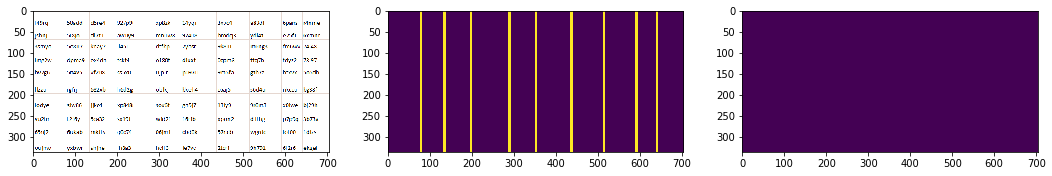


Sample Prediction after epoch 1

Epoch 2/10
600/600 [==============================] - 93s 156ms/step - loss: 4.2401e-04 - mean_iou: 0.9325 - val_loss: 1.9282e-04 - val_mean_iou: 0.9508


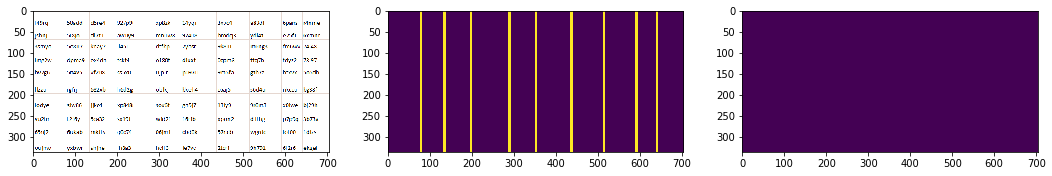


Sample Prediction after epoch 2

Epoch 3/10
600/600 [==============================] - 93s 155ms/step - loss: 0.0032 - mean_iou: 0.9584 - val_loss: 4.4161e-04 - val_mean_iou: 0.9625

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


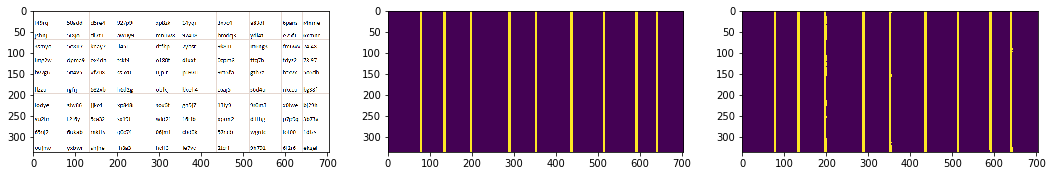


Sample Prediction after epoch 3

Epoch 4/10
600/600 [==============================] - 93s 155ms/step - loss: 5.7850e-04 - mean_iou: 0.9673 - val_loss: 1.9624e-04 - val_mean_iou: 0.9712


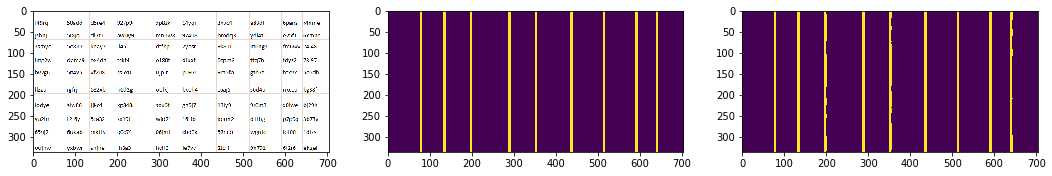


Sample Prediction after epoch 4

Epoch 5/10
600/600 [==============================] - 93s 155ms/step - loss: 4.4820e-04 - mean_iou: 0.9741 - val_loss: 1.7733e-04 - val_mean_iou: 0.9765

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


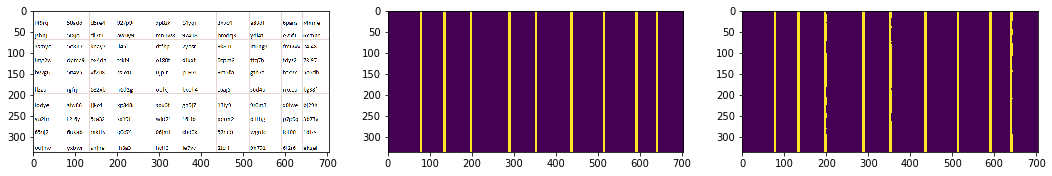


Sample Prediction after epoch 5

Epoch 6/10
600/600 [==============================] - 93s 155ms/step - loss: 3.7478e-04 - mean_iou: 0.9784 - val_loss: 1.7807e-04 - val_mean_iou: 0.9801


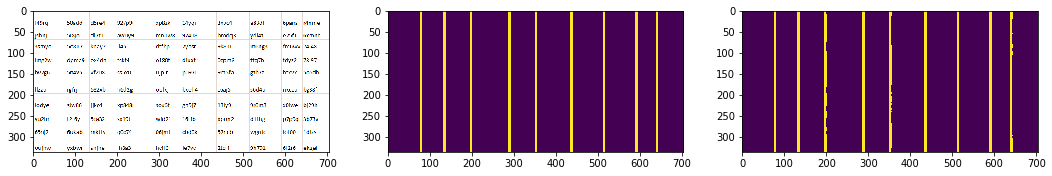


Sample Prediction after epoch 6

Epoch 7/10
600/600 [==============================] - 93s 155ms/step - loss: 3.6725e-04 - mean_iou: 0.9814 - val_loss: 1.7613e-04 - val_mean_iou: 0.9826

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


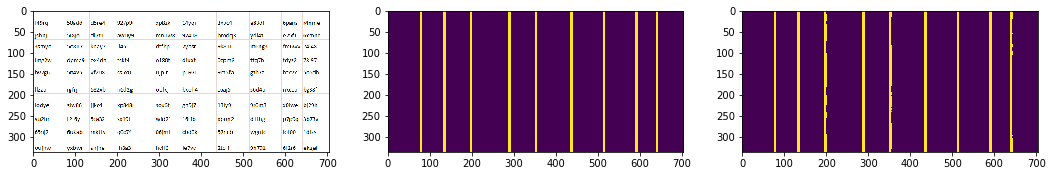


Sample Prediction after epoch 7

Epoch 8/10
600/600 [==============================] - 93s 155ms/step - loss: 3.6396e-04 - mean_iou: 0.9836 - val_loss: 1.7573e-04 - val_mean_iou: 0.9845


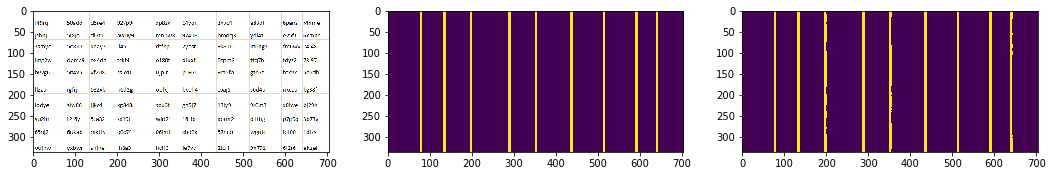


Sample Prediction after epoch 8

Epoch 9/10
600/600 [==============================] - 93s 155ms/step - loss: 3.5724e-04 - mean_iou: 0.9853 - val_loss: 1.7520e-04 - val_mean_iou: 0.9860

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.


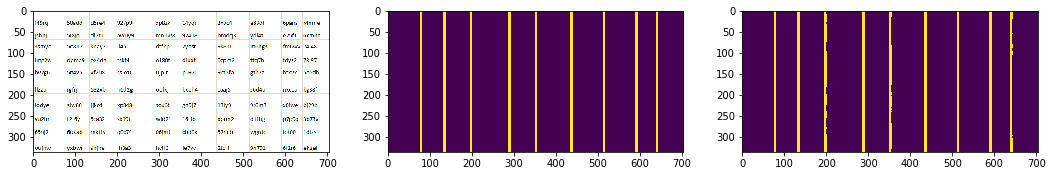


Sample Prediction after epoch 9

Epoch 10/10
600/600 [==============================] - 93s 155ms/step - loss: 3.6183e-04 - mean_iou: 0.9866 - val_loss: 1.7521e-04 - val_mean_iou: 0.9871


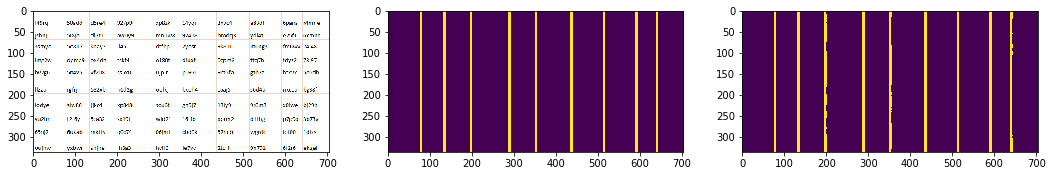


Sample Prediction after epoch 10



In [0]:
history = model.fit_generator(train_generator, validation_data=val_generator, epochs=10, steps_per_epoch=steps_per_epoch, callbacks=callbacks_list, workers=2, use_multiprocessing=True, verbose=1)

(1, 336, 704, 3) (336, 704)


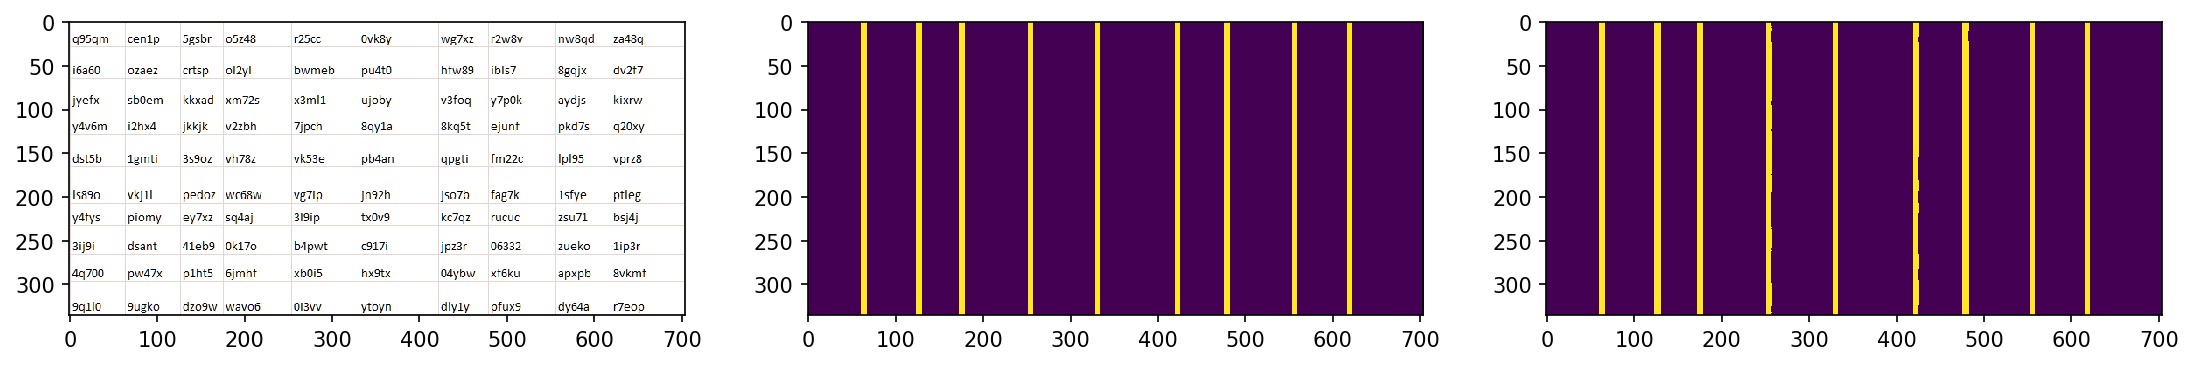

In [0]:
def predict(model, file_name_img, file_name_mask, input_height, input_width, n_classes):
    img_test = cv2.imread(file_name_img, 1)
    img_mask = cv2.imread(file_name_mask, 0)
    img_mask = cv2.resize(img_mask, (input_width, input_height),
                          interpolation=cv2.INTER_NEAREST)
    img_test = cv2.resize(img_test, (input_width, input_height),
                          interpolation=cv2.INTER_NEAREST)
    img_test = np.expand_dims(img_test, axis=0)
    print(img_test.shape, img_mask.shape)
    mask_pred_raw = model.predict(img_test.astype('float32'))
    mask_pred = mask_pred_raw.reshape((input_height, input_width, n_classes)).\
        argmin(axis=2)
    plt.figure(figsize=(18, 18), dpi=150)
    plt.subplot(1, 3, 1)
    plt.imshow(img_test[0])
    plt.subplot(1, 3, 2)
    plt.imshow(img_mask)
    plt.subplot(1, 3, 3)
    plt.imshow(mask_pred)
    plt.show()
    return mask_pred_raw


mask_pred_raw = predict(model, "image_table_val/10_table.png", "mask_column_borders_val/10_table.png", input_height, input_width, n_classes)

In [0]:
model.save(root_path + 'outputs/' + model_name + ".h5")